In [193]:
import numpy as np
import qutip as qt
from qutip import identity, sigmax, sigmay, sigmaz, tensor
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [215]:
theta=np.pi
init_state = qt.ket('000000')
plusX4 = qt.hadamard_transform(N=6)*init_state 
CP1 = qt.cphase(theta, N=6, control=0, target=1)
CP2 = qt.cphase(theta, N=6, control=1, target=2)
CP3 = qt.cphase(theta, N=6, control=2, target=3)
CP4 = qt.cphase(theta, N=6, control=3, target=4)
CP5= qt.cphase(theta, N=6, control=4, target=5)
CP6 = qt.cphase(theta, N=6, control=5, target=0)
# CP4 = qt.cphase(theta4, N=4, control=3, target=0)
cluster = (CP1 * CP2 * CP3 * CP4 * CP5 * CP6 * plusX4)

In [150]:
n_qubits = 6
targ_state_qt = qt.Qobj(qt.ket2dm((qt.ket("000000")+qt.ket("111111"))/np.sqrt(2)).full())
# target_state_qt = qt.Qobj(qt.ket2dm(cluster).full())
targ_state = tf.constant(targ_state_qt.full(), dtype = tf.float32)
basis_size = 4**n_qubits
#local sspin paulis and labels
paulis = [identity(2)/np.sqrt(2),sigmax()/np.sqrt(2),-1j*sigmay()/np.sqrt(2),sigmaz()/np.sqrt(2)]
pauli_str_labels = [r"$I$", r"$X$", r"$Y$", r"$Z$"]
basis_ls = []
index_ls = []
label_ls = []
for i in range(basis_size):
    pauli_ls = np.zeros(n_qubits, dtype=object)
    inner_idxs = []
    inner_labels = []
    for k, j in enumerate(reversed(range(n_qubits))):
        idx = (i%(4**(j+1)))//(4**j)
        inner_idxs.append(idx)
        inner_labels.append(pauli_str_labels[idx])
        # Turn basis index (Turn 1,2,3,...,N*2) into (0,0,...,0), (0,0,...,1),..., (3,3,...,3)
        # if location = (N **2,...,2,1,0) then index_val = index % (4 ** (loc + 1))// 4 ** loc
        pauli_ls[k] = paulis[idx]
        # tensor product the basis matrices and append to local dissipator basis list
    index_ls.append(inner_idxs)
    label_ls.append(r''.join(inner_labels))
    basis_ls.append(tf.constant(tensor(list(pauli_ls)), dtype=tf.float32))
# make tensorflow tensor with basis all elems except the unit trace one
basis_tf = tf.stack(basis_ls[1:], axis=0)

In [151]:
def get_jump(params, basis):
    params_broadcasted = tf.broadcast_to(params[:,:, tf.newaxis], basis_tf.shape)
    return tf.reduce_sum(params_broadcasted * basis_tf, axis=0)

def calculate_output(jump, targ_state, gamma=1):
        output = gamma*(tf.matmul(tf.matmul(jump,targ_state),jump, adjoint_b=True) -
                   (1/2)*(tf.matmul(tf.matmul(jump,jump, adjoint_a=True),targ_state)
                         + tf.matmul(targ_state,tf.matmul(jump,jump, adjoint_a=True))))
        dist = tf.reduce_sum(tf.abs(output)) 
        return dist

In [152]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100,200,500,1000, 5000], [0.1,0.01,1e-3,1e-4,1e-5, 1e-6])
params = tf.Variable(np.random.uniform(-1,1,size = (basis_size-1,1)), dtype=tf.float32)
optim_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_ls = []
steps=0
done=False
benchmark = 1000
cost_ls.append(benchmark)
count=1
while not done:
    with tf.GradientTape() as tape:
        tape.watch(params)
        # soft_params = 2*tf.keras.activations.softmax(params, axis=0) - 1.
        jump = get_jump(params, basis_tf)
        dist = calculate_output(jump, targ_state) + 1/(tf.reduce_sum(jump))
        cost_ls.append(dist)
    grads = tape.gradient(dist, params)
    optim_1.apply_gradients(zip([grads], [params]));
    print("Step: {}, Dist: {}".format(steps, dist), end='\r')
    steps+=1
    if dist<benchmark:
        best_params = params
        benchmark = dist
    if steps==10000:
        done=True

KeyboardInterrupt: 

0.9999875025226141

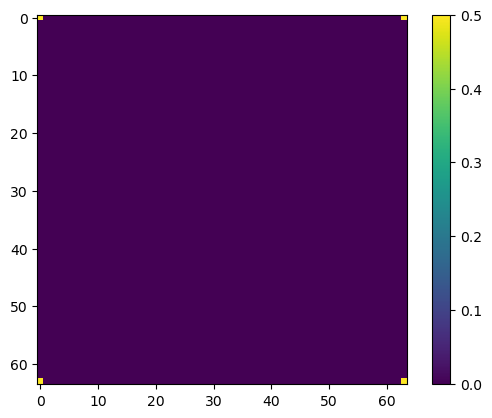

In [157]:
params = best_params
jump = get_jump(params, basis_tf)
jump_qt = qt.Qobj(jump.numpy())
H = qt.Qobj(np.zeros_like(targ_state_qt.full()))
H_super = qt.superoperator.liouvillian(H,c_ops=[jump_qt])
rho_ss = qt.steadystate(H_super, method='eigen')
plt.imshow(rho_ss.full().real)
plt.colorbar()
qt.fidelity(rho_ss, targ_state_qt)

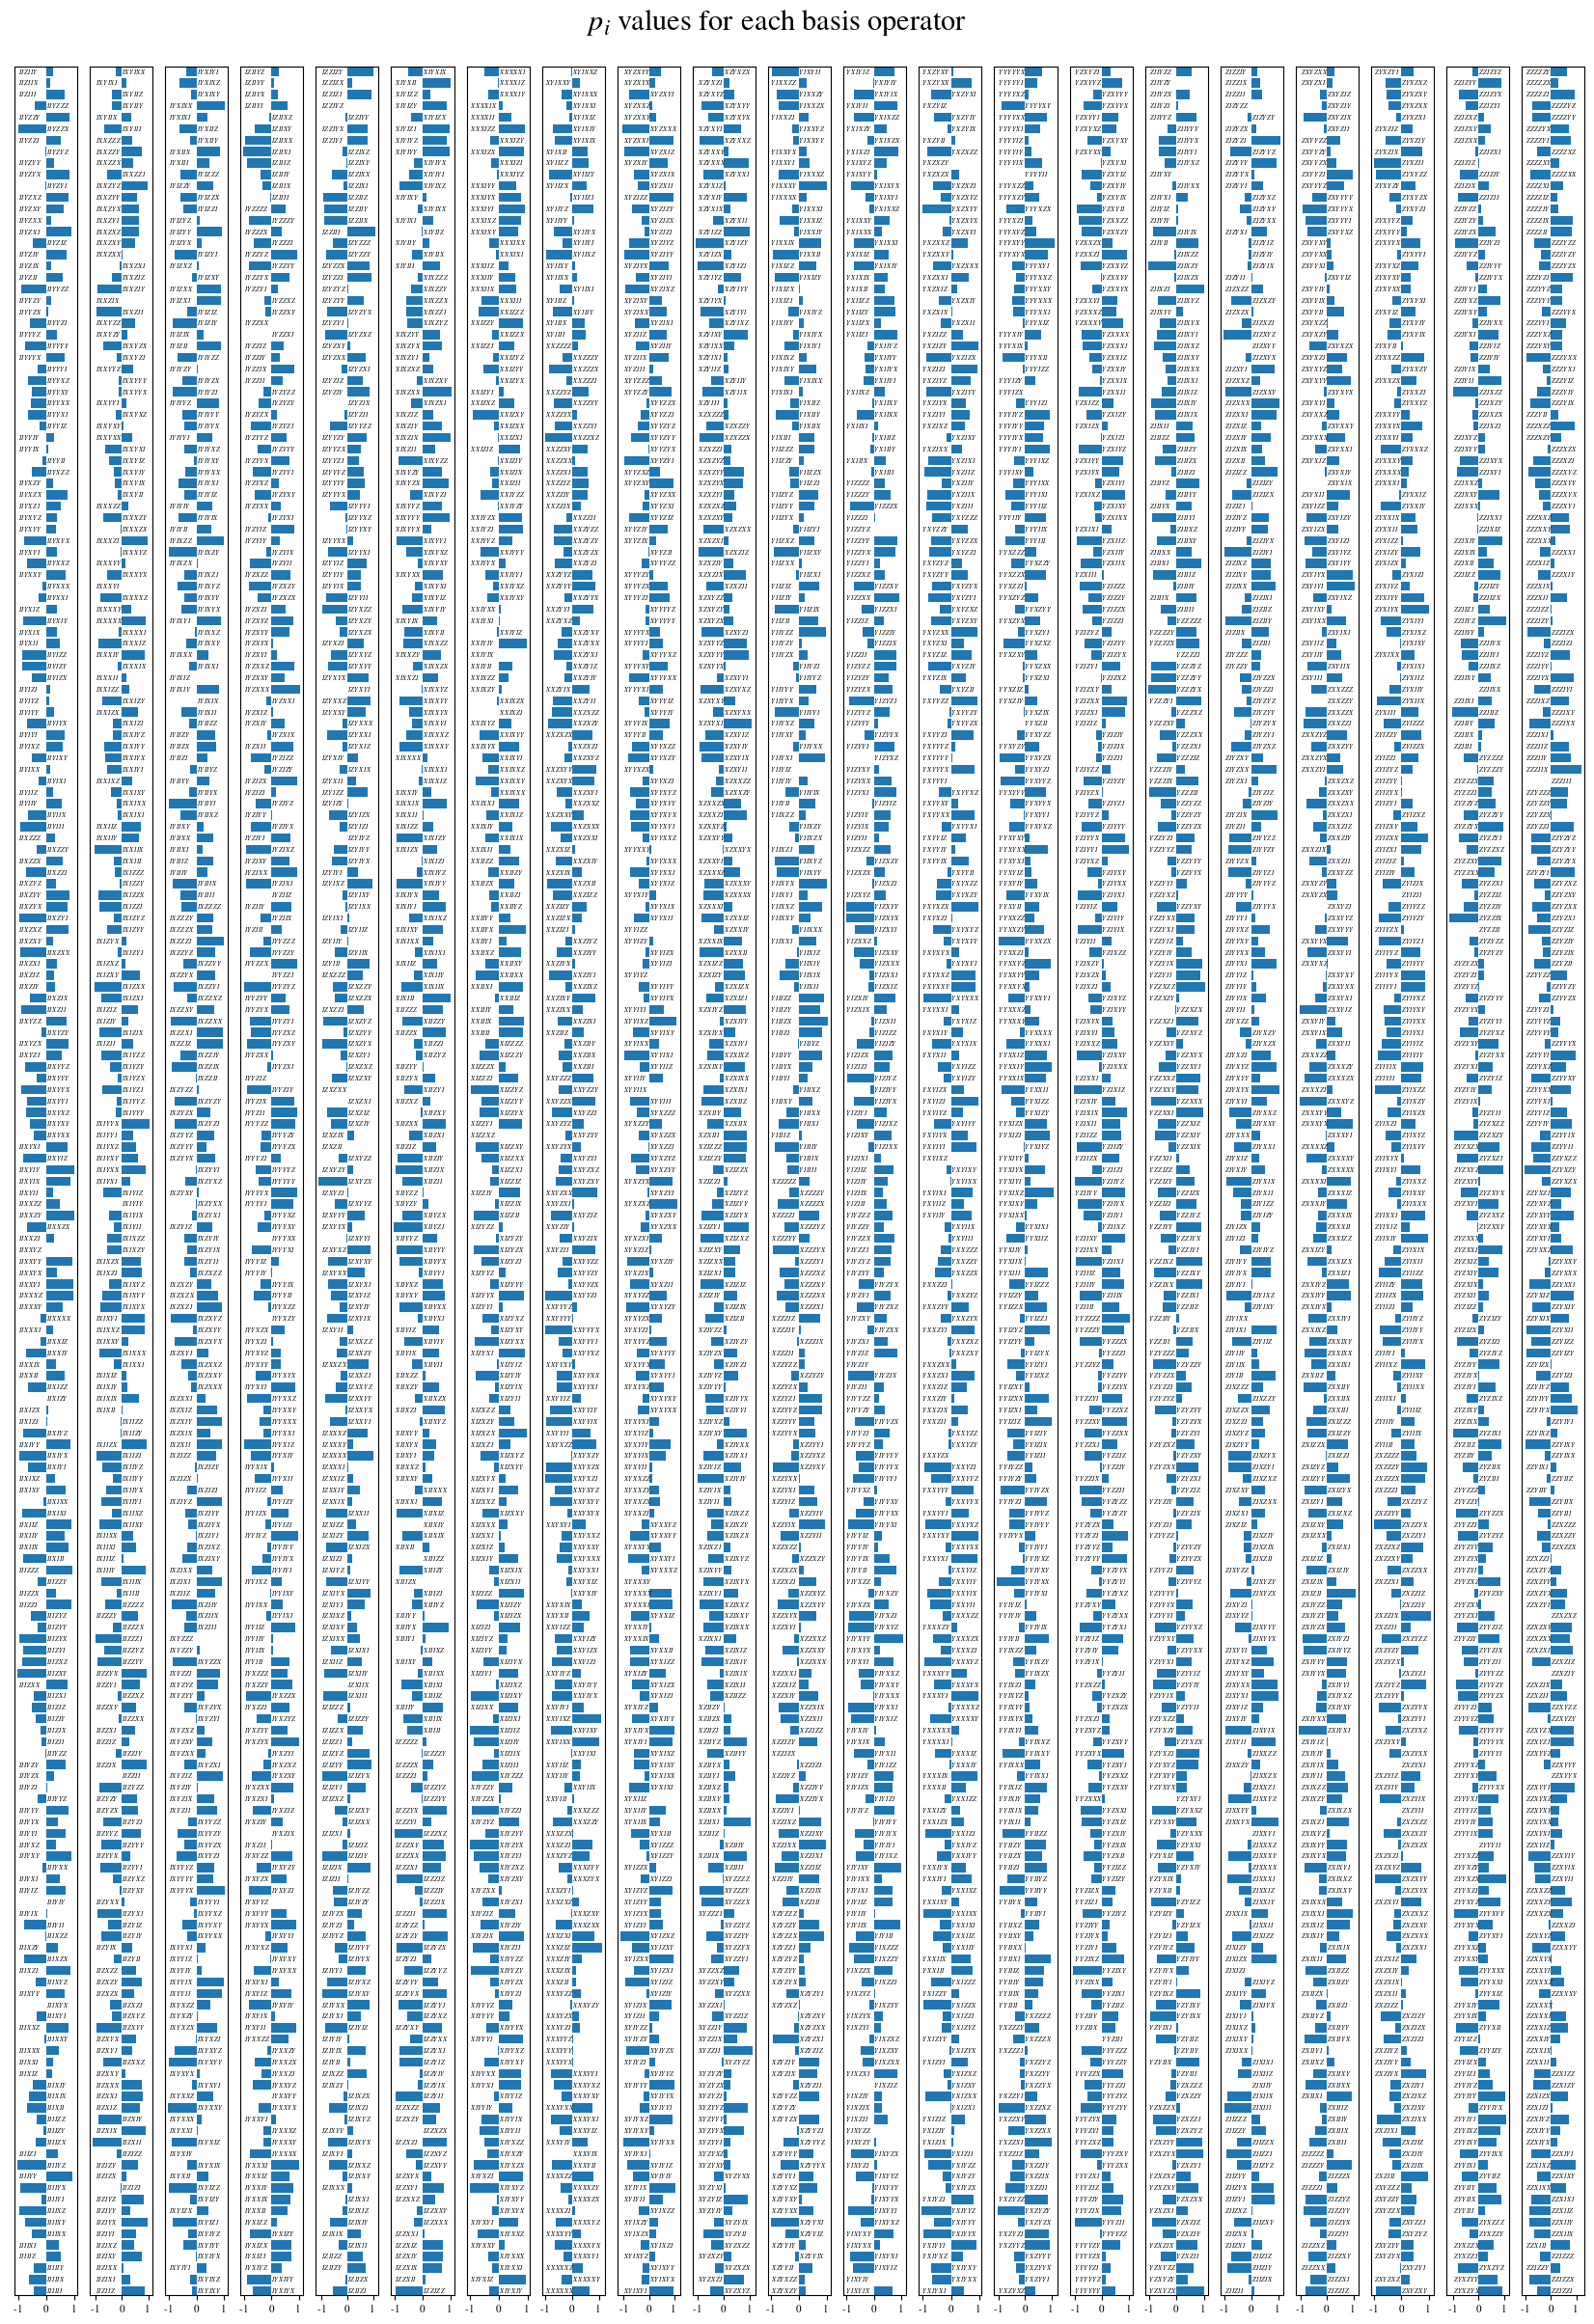

In [228]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
cols = 1
fig, axs = plt.subplots(nrows = 1, ncols=21, figsize=(21,30));
interval = 1
for i in range(21):
    axs[i].barh(np.arange(195),best_params[i*195:(i+1)*195,0]);
    axs[i].margins(y=0)
    axs[i].set_xticks([-1,0,1], [-1,0,1], fontsize=8);
    axs[i].set_yticks([], [], fontsize=5);
    for k in range(195):
        if best_params[i*195:(i+1)*195,0][k]>=0:
            axs[i].text(-1.,k-0.15,label_ls[i*195 + k],fontsize = 5)
        else:
            axs[i].text(0.,k-0.15,label_ls[i*195 + k],fontsize = 5)
plt.suptitle(r"$p_i$ values for each basis operator",x=0.5, y=0.9, fontsize=22);
plt.savefig("6QubitGHZVars", dpi=600)

<Figure size 640x480 with 0 Axes>

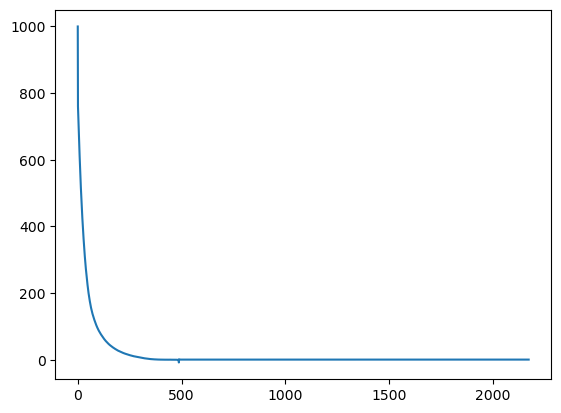

In [158]:
plt.plot(cost_ls)